# H5 文件查看

In [ ]:
 # visit函数会遍历文件中的所有对象，lambda函数会打印每个对象的名称（路径）
# f.visit(lambda x: print(x))


with h5py.File(filename, 'r') as f:
    # 打印顶层目录
    print("Top level groups:")
    for key in f.keys():
        print(f"- {key}")
        
    print("\nSecond level contents:")
    # 遍历每个顶层目录,打印其子目录/数据集
    for key in f.keys():
        print(f"\n{key}/") 
        for subkey in f[key].keys():
            print(f"  - {subkey}")


with h5py.File(filename, 'r') as f:
    # 打印全局属性
    print("Global Attributes:")
    for attr_name, attr_value in f.attrs.items():
        # 对于字节类型的属性值进行解码
        if isinstance(attr_value, bytes):
            attr_value = attr_value.decode('utf-8')
        print(f"- {attr_name}: {attr_value}")
    
    # 打印每个组的属性
    print("\nGroup Attributes:")
    for group_name in f.keys():
        print(f"\n{group_name}/ attributes:")
        group = f[group_name]
        for attr_name, attr_value in group.attrs.items():
            if isinstance(attr_value, bytes):
                attr_value = attr_value.decode('utf-8')
            print(f"  - {attr_name}: {attr_value}")
            
    # 打印数据集的属性
    print("\nDataset Attributes (example for NOMChannel01):")
    dataset = f['/Data/NOMChannel01']
    for attr_name, attr_value in dataset.attrs.items():
        if isinstance(attr_value, bytes):
            attr_value = attr_value.decode('utf-8')
        print(f"  - {attr_name}: {attr_value}")


def explore_variable(filename, variable_name):
    with h5py.File(filename, 'r') as file:
        var = file[variable_name]
        print("Shape of the variable:", var.shape)
        print("Data type of the variable:", var.dtype)
        # 打印属性
        for attr_name, attr_value in var.attrs.items():
            print(f"Attribute {attr_name}: {attr_value}")

variable_name = 'Calibration/CALChannel01'  # 替换为你感兴趣的变量名
explore_variable(filename, variable_name)


def calibrate_reflective_channel(dn, scale, offset):
    """
    将DN值转换为反射率
    """
    reflectance = dn * scale + offset
    return reflectance

# 获取特定通道的定标系数
scale = coef[channel_index-1][0]  # SCALE
offset = coef[channel_index-1][1]  # OFFSET

# 定标
reflectance = calibrate_reflective_channel(dn_data, scale, offset)

def calibrate_thermal_channel(dn, scale, offset):
    """
    将DN值转换为辐亮度
    """
    radiance = dn * scale + offset
    return radiance

# 定标
radiance = calibrate_thermal_channel(dn_data, scale, offset)


import h5py
import numpy as np

# 读取HDF文件
with h5py.File(filename, 'r') as f:
    # 读取通道数据
    # 例如读取可见光通道(0.65μm, Channel02)
    ch02 = f['/Data/NOMChannel02'][:]  
    
    # 读取定标系数
    coef = f['/Calibration/CALIBRATION_COEF(SCALE+OFFSET)'][:]   # 获取定标系数(SCALE+OFFSET)
    cal_table = f['/Calibration/CALChannel02'][:]  # 获取定标表
    
    # 读取质量标记
    quality = f['/QA/L1QualityFlag'][:]

In [ ]:
# 英杰的代码
# conding=utf-8
"""
@time: 2024/10/12 16:21
@author:lyj
@desc:此算法实现读取fy4数据。并进行等经纬数据转换
@version:V0.0.1
"""
import numpy as np
from numpy import deg2rad, rad2deg, arctan, arcsin, tan, sqrt, cos, sin
import netCDF4 as nc
import os
import xarray as xr



def get_latlons(latlons, fenbianlv=0.04):
    """
    :param latlons: [lat1, lat2,lon1,lon2]
    :param fenbianlv: 分辨率默认为０．２５
    :return: 返回经纬度二维点
    """
    return np.meshgrid(np.arange(latlons[2], latlons[3], fenbianlv), np.arange(latlons[0], latlons[1], fenbianlv)[::-1])


# def get_data(filename,group,ele):
#     if not os.path.exists(filename):
#         raise Exception('-3001|文件不存在%s'%filename)
#     ds = nc.Dataset(filename)
#     if group:
#         tmpc = ds[group][ele][:]
#         bln = ds.getncattr('Begin Line Number')
#     else:
#         tmpc = ds.variables[ele][:]
#         bln = ds.variables['geospatial_lat_lon_extent'].begin_line_number
#     return tmpc, bln

# def get_data(filename, group, ele):
#     if not os.path.exists(filename):
#         raise Exception('-3001|文件不存在%s' % filename)
#     ds = nc.Dataset(filename)
#     if group:
#         tmpc = ds[group][ele][:]
#         bln = ds.getncattr('Begin Line Number')
#     else:
#         tmpc = ds.variables[ele][:]
#         bln = ds.variables['geospatial_lat_lon_extent'].begin_line_number
#     return tmpc, bln


def get_data(filename, group, ele):
    """
    使用xarray读取 NetCDF 文件，并获取对应变量数据
    """
    if not os.path.exists(filename):
        raise FileNotFoundError(f'文件不存在: {filename}')

    # 打开数据集
    ds = xr.open_dataset(filename)  # mask_and_scale=True/False看你需要

    # 如果原代码中提到的 'Begin Line Number' 是全局属性，可以这样获取:
    begin_line_number = ds.attrs.get('Begin Line Number', 0)
    # 但有些文件把这个属性放到 geospatial_lat_lon_extent 或别的地方，
    # 你需要根据具体文件结构确定如何拿到它

    # 或者，如果在 xarray 中依然找不到全局属性，则可以访问:
    # ds['geospatial_lat_lon_extent'].attrs.get('begin_line_number', 0)
    # 具体看文件中的实际存储方式

    # group 可能在 xarray 中对应 dataset 内的子 group(如果是分组 NetCDF)
    # xarray 的层级结构可能需要 open_dataset 的 combine 参数或 open_mfdataset，
    # 如果只是同一个文件里没有真正的 group，就可以忽略 group
    if group:
        tmpc = ds[group][ele].values  # 取原始 numpy 数组
    else:
        tmpc = ds[ele].values        # 取原始 numpy 数组

    # 如果文件没有全局属性 'Begin Line Number'，但在变量中有，就根据实际写法:
    # begin_line_number = ds[ele].attrs.get('Begin Line Number', 0)
    # 或者 ds['geospatial_lat_lon_extent'].attrs.get('begin_line_number', 0)

    # 如果以前你的 netCDF4 代码是:
    #   bln = ds.variables['geospatial_lat_lon_extent'].begin_line_number
    # 在 xarray 中可能要写成:
    #   bln = ds['geospatial_lat_lon_extent'].attrs.get('begin_line_number', 0)

    # 这里给出一个示例获取方式:
    if 'geospatial_lat_lon_extent' in ds.variables:
        bln = ds['geospatial_lat_lon_extent'].attrs.get('begin_line_number', 0)
    else:
        # 如果没找到，就从全局属性中取
        bln = begin_line_number

    ds.close()  # 关闭数据集 (也可不手动关，依赖 xarray lazy 机制)

    return tmpc, bln

def linecolumn2latlon(line, column, resolution):
    """
    (line, column) → (lat, lon)
    resolution：文件名中的分辨率{'0500M', '1000M', '2000M', '4000M'}
    """
    # Step1.求x,y

    ea = 6378.137  # 地球的半长轴[km]
    eb = 6356.7523  # 地球的短半轴[km]
    h = 42164  # 地心到卫星质心的距离[km]
    Lon_Sate = 105  # 卫星星下点的经度
    XXD = deg2rad(105)  # 卫星星下点所在经度
    # 列偏移
    COFF = {"0250M": 21984,
            "0500M": 10992,
            "1000M": 5496,
            "2000M": 2748,
            "4000M": 1374}
    # 列比例因子
    CFAC = {"0250M": 163730199,
            "0500M": 81865099,
            "1000M": 40932549,
            "2000M": 20466274,
            "4000M": 10233137}
    LOFF = COFF  # 行偏移
    LFAC = CFAC  # 行比例因子
    x = deg2rad((column - COFF[resolution]) / (2 ** -16 * CFAC[resolution]))
    y = deg2rad((line - LOFF[resolution]) / (2 ** -16 * LFAC[resolution]))
    # Step2.求sd,sn,s1,s2,s3,sxy
    cosx = cos(x)
    cosy = cos(y)
    siny = sin(y)
    cos2y = cosy ** 2
    hcosxcosy = h * cosx * cosy
    cos2y_ea_eb_siny_2 = cos2y + (ea / eb * siny) ** 2
    sd = sqrt(hcosxcosy ** 2 - cos2y_ea_eb_siny_2 * (h ** 2 - ea ** 2))
    sn = (hcosxcosy - sd) / cos2y_ea_eb_siny_2
    s1 = h - sn * cosx * cosy
    s2 = sn * sin(x) * cosy
    s3 = -sn * siny
    sxy = sqrt(s1 ** 2 + s2 ** 2)
    # Step3.求lon,lat
    lon = rad2deg(arctan(s2 / s1) + XXD)
    lat = rad2deg(arctan(ea ** 2 / eb ** 2 * s3 / sxy))
    return lat, lon


def latlon2linecolumn(lat, lon, resolution='4000M'):
    """
    (lat, lon) → (line, column)
    resolution：文件名中的分辨率{'0500M', '1000M', '2000M', '4000M'}
    line, column不是整数
    """
    # Step1.检查地理经纬度
    # Step2.将地理经纬度的角度表示转化为弧度表示
    ea = 6378.137  # 地球的半长轴[km]
    eb = 6356.7523  # 地球的短半轴[km]
    h = 42164  # 地心到卫星质心的距离[km]
    Lon_Sate = 105  # 卫星星下点的经度
    XXD = deg2rad(105)  # 卫星星下点所在经度
    # 列偏移
    COFF = {"0250M": 21984,
            "0500M": 10992,
            "1000M": 5496,
            "2000M": 2748,
            "4000M": 1374}
    # 列比例因子
    CFAC = {"0250M": 163730199,
            "0500M": 81865099,
            "1000M": 40932549,
            "2000M": 20466274,
            "4000M": 10233137}
    LOFF = COFF  # 行偏移
    LFAC = CFAC  # 行比例因子
    lat = deg2rad(lat)
    lon = deg2rad(lon)
    # Step3.将地理经纬度转化成地心经纬度
    eb2_ea2 = eb ** 2 / ea ** 2
    lmd_e = lon
    f_e = arctan(eb2_ea2 * tan(lat))
    # Step4.求Re
    cosf_e = cos(f_e)
    re = eb / sqrt(1 - (1 - eb2_ea2) * cosf_e ** 2)
    # Step5.求r1,r2,r3
    lmd_e_XXD = lmd_e - XXD
    r1 = h - re * cosf_e * cos(lmd_e_XXD)
    r2 = -re * cosf_e * sin(lmd_e_XXD)
    r3 = re * sin(f_e)
    # Step6.求rn,x,y
    rn = sqrt(r1 ** 2 + r2 ** 2 + r3 ** 2)
    x = rad2deg(arctan(-r2 / r1))
    y = rad2deg(arcsin(-r3 / rn))
    # Step7.求c,l
    column = COFF[resolution] + x * 2 ** -16 * CFAC[resolution]
    line = LOFF[resolution] + y * 2 ** -16 * LFAC[resolution]
    return line, column


def get_latlons_data(latlons, datas, begin_line_number, resolution):
    lons, lats = get_latlons(latlons)
    lines, column = latlon2linecolumn(lats, lons, resolution)
    lines = np.rint(lines.flatten()).astype(int) - begin_line_number
    column = np.rint(column.flatten()).astype(int)
    datas = datas[lines, column].reshape(lons.shape)
    return datas, lats, lons



import h5py
import numpy as np
import geopandas as gpd
from rasterio.transform import from_origin
from rasterio.mask import mask
from typing import Tuple

class GeoTransformer:
    """地理坐标转换工具类"""
    # FY-4A AGRI 参数 (根据官方文档调整)
    EA = 6378.137  # 地球半长轴 [km]
    EB = 6356.7523  # 地球半短轴 [km]
    H = 42164  # 卫星高度 [km]
    LON_SATE = 105  # 卫星星下点经度
    
    # 不同分辨率参数表 (根据FY-4B文档更新)
    RES_PARAMS = {
        '4000M': {
            'COFF': 1374,
            'CFAC': 10233137,
            'LOFF': 1374,
            'LFAC': 10233137
        },
        # 可扩展其他分辨率
    }

    @classmethod
    def linecol_to_latlon(cls, line: np.ndarray, column: np.ndarray, resolution: str) -> Tuple[np.ndarray, np.ndarray]:
        """行列号转经纬度"""
        params = cls.RES_PARAMS[resolution]
        x = np.deg2rad((column - params['COFF']) / (2**-16 * params['CFAC']))
        y = np.deg2rad((line - params['LOFF']) / (2**-16 * params['LFAC']))
        
        # 向量化计算
        cosx, cosy = np.cos(x), np.cos(y)
        siny = np.sin(y)
        hcosxcosy = cls.H * cosx * cosy
        cos2y_ea_eb_siny_2 = cosy**2 + (cls.EA/cls.EB * siny)**2
        
        sd = np.sqrt(hcosxcosy**2 - cos2y_ea_eb_siny_2 * (cls.H**2 - cls.EA**2))
        sn = (hcosxcosy - sd) / cos2y_ea_eb_siny_2
        
        s1 = cls.H - sn * cosx * cosy
        s2 = sn * np.sin(x) * cosy
        s3 = -sn * siny
        sxy = np.sqrt(s1**2 + s2**2)
        
        lon = np.rad2deg(np.arctan2(s2, s1)) + cls.LON_SATE
        lat = np.rad2deg(np.arctan2(cls.EA**2/cls.EB**2 * s3, sxy))
        return lat, lon

    @classmethod
    def generate_geo_grid(cls, shape: Tuple[int, int], resolution: str) -> Tuple[np.ndarray, np.ndarray]:
        """生成经纬度网格"""
        lines = np.arange(shape[0])
        cols = np.arange(shape[1])
        return cls.linecol_to_latlon(lines[:, None], cols[None, :], resolution)

class AgriDataProcessor:
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.metadata = {}
        self.raw_data = {}
        # self._geo_cache = {}  # 缓存地理网格
        
    def _read_geo_params(self):
        """从HDF文件读取地理参数"""
        with h5py.File(self.filepath, 'r') as f:
            self.metadata['resolution'] = f.attrs['Space Resolution'][0].decode()
            self.metadata.update({
                'semimajor': f.attrs['Semimajor axis of ellipsoid'][0],
                'semiminor': f.attrs['Semiminor axis of ellipsoid'][0],
                'sat_lon': f.attrs['NOMCenterLon'][0],
                'sat_lat': f.attrs['NOMCenterLat'][0]
            })
    
    def get_geo_grid(self) -> Tuple[np.ndarray, np.ndarray]:
        """获取经纬度网格"""
        if 'grid' not in self._geo_cache:
            self._read_geo_params()
            lats, lons = GeoTransformer.generate_geo_grid(
                (2748, 2748),  # 根据实际数据维度调整
                self.metadata['resolution']
            )
            self._geo_cache['grid'] = (lats, lons)
        return self._geo_cache['grid']
    
    def clip_with_shapefile(self, data: np.ndarray, shapefile: str) -> np.ndarray:
        """基于精确地理网格裁剪"""
        lats, lons = self.get_geo_grid()
        
        # 构建坐标转换矩阵
        transform = from_origin(
            lons.min(), lats.max(),
            abs(lons[0,1]-lons[0,0]), abs(lats[1,0]-lats[0,0])
        )
        
        # 执行裁剪
        gdf = gpd.read_file(shapefile).to_crs(epsg=4326)
        clipped, _ = mask(
            [data], 
            shapes=gdf.geometry,
            transform=transform,
            crop=True
        )
        return clipped[0]

    def get_pixel_value(self, lat: float, lon: float) -> float:
        """获取指定经纬度的像素值"""
        pass
     
# ---------------------- 使用示例 ----------------------
processor = AgriDataProcessor('FY4B.HDF')
data = processor.read_data('NOMChannel01')

# 获取地理网格
lats, lons = processor.get_geo_grid()

# 精确裁剪
clipped = processor.clip_with_shapefile(data, 'china.shp')

# 获取单点值
pixel_value = processor.get_pixel_value(30.5, 120.3)

In [ ]:


import h5py
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from rasterio.mask import mask
from datetime import datetime

class AgriDataProcessor:
    def __init__(self, filepath):
        self.filepath = filepath
        self.metadata = {}
        self.raw_data = {}
        self.proj_info = {}
        
    def read_data(self, channel='NOMChannel01'):
        """读取HDF文件数据和元数据"""
        with h5py.File(self.filepath, 'r') as f:
            # 读取通道数据
            self.raw_data[channel] = f[f'Data/{channel}'][:]
            
            # 读取全局属性
            self.metadata = {
                'obs_time': datetime.strptime(
                    f.attrs['Observing Beginning Date'].decode() + ' ' + 
                    f.attrs['Observing Beginning Time'].decode(),
                    '%Y-%m-%d %H:%M:%S.%f'
                ),
                'sat_lon': f.attrs['NOMCenterLon'][0],
                'sat_lat': f.attrs['NOMCenterLat'][0],
                'resolution': 4.0  # km
            }
            
            # 读取投影参数
            self.proj_info = {
                'semimajor': f.attrs['Semimajor axis of ellipsoid'][0],
                'semiminor': f.attrs['Semiminor axis of ellipsoid'][0],
                'height': f.attrs['NOMSatHeight'][0],
                'lon_center': f.attrs['NOMCenterLon'][0]
            }
            
        print(f"已加载通道 {channel} 数据")
        return self.raw_data[channel]
    
    def calibrate(self, channel='NOMChannel01', output_type='reflectance'):
        """数据定标处理"""
        with h5py.File(self.filepath, 'r') as f:
            # 获取通道索引（1-15）
            channel_idx = int(channel[-2:]) - 1
            
            # 读取定标系数
            scale, offset = f['Calibration/CALIBRATION_COEF'][channel_idx]
            
            if output_type == 'reflectance' and channel_idx < 6:
                # 反射通道处理
                dn_data = self.raw_data[channel].astype(np.float32)
                calibrated = dn_data * scale + offset
                
            elif output_type == 'radiance' and channel_idx >= 6:
                # 热红外通道辐亮度
                dn_data = self.raw_data[channel].astype(np.float32)
                calibrated = dn_data * scale + offset
                
            elif output_type == 'brightness_temp':
                # 亮温（需使用查找表）
                cal_table = f[f'Calibration/CALChannel{channel_idx+1:02d}'][:]
                calibrated = np.interp(self.raw_data[channel], 
                                      np.arange(len(cal_table)), cal_table)
            else:
                raise ValueError("不支持的通道类型或输出类型")
                
        return calibrated
    
    def clean_data(self, data, fill_earth=True):
        """数据清洗处理"""
        # 地球外无效值
        cleaned = np.where(self.raw_data == 65535, np.nan, data)
        
        # 地球内无效值
        if fill_earth:
            cleaned = np.where(self.raw_data == 65534, np.nan, cleaned)
            
        return cleaned
    
    def clip_with_shapefile(self, data, shapefile_path):
        """使用矢量文件裁剪数据"""
        # 生成假地理坐标（实际应使用GLT校正）
        # 此处假设为等经纬度投影
        lat = np.linspace(-60, 60, data.shape[0])
        lon = np.linspace(50, 160, data.shape[1])
        
        # 转换坐标系
        gdf = gpd.read_file(shapefile_path).to_crs(epsg=4326)
        geometry = gdf.geometry.values
        
        # 创建虚拟transform矩阵
        from affine import Affine
        transform = Affine(0.04, 0, 50,
                         0, -0.04, 60)
        
        # 执行裁剪
        out_image, _ = mask(dataset=[data], 
                           shapes=geometry,
                           transform=transform,
                           crop=True)
        return out_image[0]
    
    def process_pipeline(self, channel='NOMChannel01', 
                        output_type='reflectance',
                        shapefile_path=None):
        """处理流水线"""
        # 1. 读取数据
        raw = self.read_data(channel)
        
        # 2. 定标
        calibrated = self.calibrate(channel, output_type)
        
        # 3. 清洗
        cleaned = self.clean_data(calibrated)
        
        # 4. 裁剪
        if shapefile_path:
            final_data = self.clip_with_shapefile(cleaned, shapefile_path)
        else:
            final_data = cleaned
            
        return final_data


# ---------------------- 可视化函数（供Jupyter单独调用） ----------------------
def plot_geo_image(data, metadata, style='reflectance', title=None):
    """地理数据可视化"""
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # 添加地理要素
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    
    # 设置色图
    cmap = 'viridis' if style == 'reflectance' else 'plasma'
    vmin, vmax = (0, 1) if style == 'reflectance' else (200, 320)
    
    # 显示数据
    img = ax.imshow(data, extent=[50, 160, -60, 60],  # 全圆盘范围
                   origin='upper', cmap=cmap, vmin=vmin, vmax=vmax,
                   transform=ccrs.PlateCarree())
    
    # 添加色标
    cbar = plt.colorbar(img, shrink=0.8)
    cbar.set_label('反射率' if style == 'reflectance' else '亮温 (K)')
    
    # 标题
    title = title or f"FY-4B AGRI 数据 ({metadata['obs_time']:%Y-%m-%d %H:%M})"
    plt.title(title)
    
    plt.show()

def plot_histogram(data, bins=100):
    """数据分布直方图"""
    plt.figure(figsize=(10, 4))
    plt.hist(data[~np.isnan(data)].flatten(), bins=bins, alpha=0.7)
    plt.xlabel('值')
    plt.ylabel('频数')
    plt.title('数据分布直方图')
    plt.grid(True, alpha=0.3)
    plt.show()

    

# FY4B Satpy 部分

In [3]:
from osgeo import gdal,osr
import h5py
import numpy as np

In [2]:
import os, glob
from satpy.scene import Scene
import os

In [3]:
File = '/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.HDF'

In [4]:
filenames = glob.glob('/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_*_4000M_V*.HDF')
print(filenames)

['/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.HDF']


In [5]:
filenames = glob.glob('/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_*_4000M_V*.HDF')
# 创建scene对象
scn = Scene(filenames,reader='agri_fy4b_l1')

# 查看可用的通道
scn.available_dataset_names()

🔄 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.HDF'}, 选择文件类型: ['/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/etc/readers/agri_fy4b_l1.yaml']
 init 传参 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.HDF'}


['C01',
 'C02',
 'C03',
 'C04',
 'C05',
 'C06',
 'C07',
 'C08',
 'C09',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15']

In [8]:
# 以红外通道为例
ir_channel = 'C12'
scn.load([ir_channel], generate=False, calibration='brightness_temperature')

In [11]:
china_scene_12 = scn.resample('china_4km')

In [12]:
china_scene_12.show(ir_channel)

In [10]:
# 在notebook中显示
scn.show(ir_channel)

In [58]:
# 转换为 Xarray Dataset
ds = scn.to_xarray_dataset()

from datetime import datetime

# 添加大小为1的时间维度（假设当前时次时间为2025-02-26 07:00:02）
ds = ds.expand_dims(dim={'time': [datetime(2025,2,26,7,0,2)]})

# 验证维度结构
print(ds.attrs)
# 现在维度应为：time:1, y:2748, x:2748

# # 查看数据结构
# print(ds)
# # 输出应包含维度：time, y, x 和变量 C12

In [54]:
from numcodecs import Blosc

# # 设置分块策略和压缩参数
# encoding = {
#     'C12': {
#         'chunks': (1, 500, 500),  # 时间分块=1, 空间分块=500x500
#         'compressor': Blosc(cname='zstd', clevel=3),  # 使用Zstandard压缩
#         'dtype': 'float32',  # 降低精度节省存储
#         'scale_factor': 0.1  # 可选量化
#     }
# }


encoding = {
    'C12': {
        'chunks': (1, 500, 500),
        'compressor': Blosc(cname='zstd', clevel=3),
        'dtype': 'float32',
        'scale_factor': 0.1
    },
    'crs': {'dtype': 'str'}  # 显式指定字符串类型
}

# # 重命名维度为更直观的名称（可选）
# ds = ds.rename({'y': 'lat', 'x': 'lon'})

In [94]:
import xarray as xr
import numpy   as np

In [95]:
print(ds.crs.dtype)  # 预期输出：object

In [96]:
# 转换为 Xarray Dataset
ds = scn.to_xarray_dataset()

from datetime import datetime

# 添加大小为1的时间维度（假设当前时次时间为2025-02-26 07:00:02）
ds = ds.expand_dims(dim={'time': [datetime(2025,2,26,7,0,2)]})

# 验证维度结构

In [90]:
ds.attrs

In [100]:
def sanitize_attrs(attrs):
    """递归清理属性字典，兼容元组和数组类型的area_extent"""
    sanitized = {}
    for key, value in attrs.items():
        if isinstance(value, np.ndarray):
            sanitized[key] = value.tolist()
        elif isinstance(value, np.generic):
            sanitized[key] = value.item()
        elif isinstance(value, AreaDefinition):
            # 处理AreaDefinition的area_extent（兼容元组/数组）
            area_extent = value.area_extent
            if isinstance(area_extent, (np.ndarray, tuple)):
                area_extent = list(area_extent)  # 统一转为列表
            else:
                area_extent = str(area_extent)  # 其他类型转为字符串
            
            sanitized[key] = sanitize_attrs({
                'area_id': value.area_id,
                'crs': str(value.crs),  # 提取CRS信息
                'width': value.width,
                'height': value.height,
                'area_extent': area_extent  # 确保是列表
            })
        elif hasattr(value, 'to_dict'):
            sanitized_value = value.to_dict()
            sanitized[key] = sanitize_attrs(sanitized_value)
        elif isinstance(value, dict):
            sanitized[key] = sanitize_attrs(value)
        elif isinstance(value, (list, tuple)):
            sanitized[key] = [
                sanitize_attrs(v) if isinstance(v, dict) else 
                v.tolist() if isinstance(v, np.ndarray) else 
                list(v) if isinstance(v, tuple) else  # 处理元组
                v.item() if isinstance(v, np.generic) else v
                for v in value
            ]
        else:
            try:
                json.dumps({'test': value})  # 验证可序列化
                sanitized[key] = value
            except TypeError:
                sanitized[key] = str(value)
    return sanitized

# 清理属性
ds.attrs = sanitize_attrs(ds.attrs)

# 确保每个变量的属性也被清理
for var in ds.variables.values():
    var.attrs = sanitize_attrs(var.attrs) 

In [101]:
# 清理属性
ds.attrs = sanitize_attrs(ds.attrs)

# 确保每个变量的属性也被清理
for var in ds.variables.values():
    var.attrs = sanitize_attrs(var.attrs) 

In [102]:
# 保存到 Zarr
ds.chunk({'time': 1, 'y': 500, 'x': 500}).to_zarr(
    '/Users/liyujia/Projects/FY4B-data-processing/FY4B_CloudBase.zarr',
    encoding=encoding,
    mode='w',  # 覆盖写入
    consolidated=True  # 生成元数据整合文件
)

In [ ]:
# 追加时次
# 读取现有存储
existing = xr.open_zarr('/path/to/FY4B_CloudBase.zarr')

# 处理新数据并添加时间维度
new_ds = new_scn.to_xarray_dataset().expand_dims('time')

# 追加到现有存储
new_ds.chunk({'time': 1, 'y': 500, 'x': 500}).to_zarr(
    '/path/to/FY4B_CloudBase.zarr',
    encoding=encoding,
    mode='a',  # append模式
    append_dim='time'  # 指定扩展维度
)

In [32]:
# 查看可用的合成选项
scn.available_composite_names()

In [28]:

composite = 'true_color'
scn.load([composite])
scn.show(composite)
# scn.save_dataset(composite, filename='{sensor}_{name}.png')

In [42]:
# os.environ['PPP_CONFIG_DIR'] = '/Users/liyujia/Projects/FY4B-data-processing/configs'
china_scene = scn.resample('china_4km')

In [44]:
china_scene.show(composite)

In [10]:

import glob
from satpy import Scene
import xarray as xr
from datetime import datetime

# 读取L1数据
filenames = glob.glob('/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_*_4000M_V*.HDF')
scn = Scene(filenames, reader='agri_fy4b_l1')

# channels = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 
#            'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15']
composite = 'true_color'
scn.load([composite])
china_scene_eqc = scn.resample('china_4km_eqc')



In [12]:
china_scene_eqc.show(composite)

In [10]:
from satpy import Scene

In [24]:
filenames = glob.glob('/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--*.NC')
print(filenames)

In [ ]:
# 创建scene对象
scn = Scene(filenames,reader='agri_fy4b_l2')

# 查看可用的通道
scn.available_dataset_names()

In [18]:
from satpy import available_readers

clm_file_path = '/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'
print("Available readers:", available_readers())

import logging
logging.basicConfig(level=logging.DEBUG)  # 显示详细日志

from satpy import Scene
clm_file_path = "/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC"
scn = Scene(reader="agri_fy4b_l2", filenames=[clm_file_path])
scn.load(["cloud_mask"])



from satpy.readers import load_readers

# 假设你的文件路径和读取器名称
filenames = ['/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC']
reader = 'agri_fy4b_l2'

# 加载读取器并打印配置
readers = load_readers(filenames=filenames, reader=reader)
for reader_name, reader_instance in readers.items():
    print(f"Reader: {reader_name}")
    print(f"Configuration: {reader_instance.config}")



scn2 = Scene(reader = 'agri_fy4b_l2' , filenames = [clm_file_path])
scn2.load(['cloud_mask'])
print(scn2.available_dataset_names())




In [ ]:
from pyresample import get_area_def

area_id = 'lekima'

x_size = 549
y_size = 499
area_extent = (-1098006.560556, -967317.140452, 1098006.560556, 1026777.426728)
projection = '+proj=laea +lat_0=19.0 +lon_0=128.0 +ellps=WGS84'
description = "Typhoon Lekima"
proj_id = 'laea_128.0_19.0'

areadef = get_area_def(area_id, description, proj_id, projection,x_size, y_size, area_extent)



In [34]:
# 检查原始scn中的可用数据集
print("Available datasets in original scene:")
print(scn.available_dataset_names())

In [35]:
# 确保在重采样前加载所有通道
channels = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 
            'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15']
scn.load(channels)

# 再次检查加载后的数据
print("Loaded datasets:")
print(scn.available_dataset_names())

In [36]:
from pyresample import create_area_def

# 修改投影定义 - 使用更适合FY4B数据的参数
china_area = create_area_def(
    area_id='china',
    name='china_4km',
    projection={'proj': 'eqc', 'datum': 'WGS84'},  # 等距圆柱投影可能更适合
    width=1550,
    height=900,
    area_extent=[73, 18, 135, 54],  # [west, south, east, north]
)

# 执行重投影裁剪
scn_resampled = scn.resample(china_area)

# 检查重采样后的结果
print("Available datasets after resampling:")
print(scn_resampled.available_dataset_names())

In [37]:
# 获取原始数据的区域定义
original_area = scn[scn.available_dataset_names()[0]].attrs['area']
print("Original area definition:", original_area)

# 制作Zarr -TEST

In [136]:
filenames = glob.glob('/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_*_4000M_V*.HDF')
# 创建scene对象
scn = Scene(filenames,reader='agri_fy4b_l1')

channels = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 
           'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15']

scn.load(channels, generate=False)

In [137]:
china_scene = scn.resample('china_4km')

In [138]:
# 转换为 Xarray Dataset
ds = scn.to_xarray_dataset()

from datetime import datetime

# 添加大小为1的时间维度（假设当前时次时间为2025-02-26 07:00:02）
ds = ds.expand_dims(dim={'time': [datetime(2025,2,26,7,0,2)]})

# 验证维度结构
print(ds.attrs)
# 现在维度应为：time:1, y:2748, x:2748

# # 查看数据结构
# print(ds)
# # 输出应包含维度：time, y, x 和变量 C12

In [139]:
from numcodecs import Blosc

# # 设置分块策略和压缩参数
# encoding = {
#     'C12': {
#         'chunks': (1, 500, 500),  # 时间分块=1, 空间分块=500x500
#         'compressor': Blosc(cname='zstd', clevel=3),  # 使用Zstandard压缩
#         'dtype': 'float32',  # 降低精度节省存储
#         'scale_factor': 0.1  # 可选量化
#     }
# }


# encoding = {
#     'C12': {
#         'chunks': (1, 500, 500),
#         'compressor': Blosc(cname='zstd', clevel=3),
#         'dtype': 'float32',
#         'scale_factor': 0.1
#     },
#     'crs': {'dtype': 'str'}  # 显式指定字符串类型
# }


# 创建所有通道的编码配置
channels = [f'C{str(i).zfill(2)}' for i in range(1, 16)]  # 生成C01到C15
encoding = {
    channel: {
        'chunks': (1, 500, 500),
        'compressor': Blosc(cname='zstd', clevel=3),
        'dtype': 'float32',
    } for channel in channels
}
encoding['crs'] = {'dtype': 'str'}  # 添加crs配置


In [140]:
print(encoding)

In [141]:

def sanitize_attrs(attrs):
    """递归清理属性字典，兼容元组和数组类型的area_extent"""
    sanitized = {}
    for key, value in attrs.items():
        if isinstance(value, np.ndarray):
            sanitized[key] = value.tolist()
        elif isinstance(value, np.generic):
            sanitized[key] = value.item()
        elif isinstance(value, AreaDefinition):
            # 处理AreaDefinition的area_extent（兼容元组/数组）
            area_extent = value.area_extent
            if isinstance(area_extent, (np.ndarray, tuple)):
                area_extent = list(area_extent)  # 统一转为列表
            else:
                area_extent = str(area_extent)  # 其他类型转为字符串
            
            sanitized[key] = sanitize_attrs({
                'area_id': value.area_id,
                'crs': str(value.crs),  # 提取CRS信息
                'width': value.width,
                'height': value.height,
                'area_extent': area_extent  # 确保是列表
            })
        elif hasattr(value, 'to_dict'):
            sanitized_value = value.to_dict()
            sanitized[key] = sanitize_attrs(sanitized_value)
        elif isinstance(value, dict):
            sanitized[key] = sanitize_attrs(value)
        elif isinstance(value, (list, tuple)):
            sanitized[key] = [
                sanitize_attrs(v) if isinstance(v, dict) else 
                v.tolist() if isinstance(v, np.ndarray) else 
                list(v) if isinstance(v, tuple) else  # 处理元组
                v.item() if isinstance(v, np.generic) else v
                for v in value
            ]
        else:
            try:
                json.dumps({'test': value})  # 验证可序列化
                sanitized[key] = value
            except TypeError:
                sanitized[key] = str(value)
    return sanitized

# 清理属性
ds.attrs = sanitize_attrs(ds.attrs)

# 确保每个变量的属性也被清理
for var in ds.variables.values():
    var.attrs = sanitize_attrs(var.attrs) 

In [142]:
print(ds)

In [143]:
# 清理每个数据变量的属性
for var_name in ds.data_vars:
    var = ds[var_name]
    # 删除与编码参数冲突的属性
    for key in ['scale_factor', 'add_offset', '_FillValue']:
        if key in var.attrs:
            # print(f"{key} 属性,{ds.data_vars[var_name].attrs}")
            print(f"{key} 属性")    
            del var.attrs[key]

In [144]:
# 问题是crs居然变成了一个变量
# 保存到 Zarr
ds.chunk({'time': 1, 'y': 500, 'x': 500}).to_zarr(
    '/Users/liyujia/Projects/FY4B-data-processing/FY4B_CloudBase.zarr',
    encoding=encoding,
    mode='w',  # 覆盖写入
    consolidated=True  # 生成元数据整合文件
)

# 制作NC

In [1]:
clm_file_path = '/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'


logging.basicConfig(level=logging.DEBUG)  # 显示详细日志
scn2 = Scene(reader = 'agri_fy4b_l2' , filenames = [clm_file_path])
scn2.load(['CLM'])
# print(scn2.available_dataset_names())


NameError: name 'logging' is not defined

In [3]:
import os, glob
from satpy.scene import Scene
import os

In [4]:
filenames = glob.glob('/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_*_4000M_V*.HDF')
# 创建scene对象
scn = Scene(filenames,reader='agri_fy4b_l1')

channels = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 
           'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15']


In [5]:
scn.load(channels, generate=False)
china_scene = scn.resample('china_4km')

In [6]:
l2_file_path = '/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'
scn2 = Scene(reader = 'agri_fy4b_l2' , filenames = [l2_file_path])
scn2.load(['CLM'])
china_scene2 = scn2.resample('china_4km')


In [17]:
china_scene2.show('CLM')

In [13]:
import xarray as xr
import numpy as np
import json
from datetime import datetime

# Assuming scn is already created and channels are loaded
# china_scene = scn.resample('china_4km')

# Convert to xarray Dataset
ds = china_scene.to_xarray_dataset()
ds2 = china_scene2.to_xarray_dataset()

# Add time dimension if needed
ds = ds.expand_dims(dim={'time': [datetime(2025,2,26,7,0,2)]})  # Adjust date as needed
ds2 = ds2.expand_dims(dim={'time': [datetime(2025,2,26,7,0,2)]})

# 合并两个数据集
ds_combined = xr.merge([ds, ds2])


In [16]:

# Improved function to sanitize attributes for NetCDF compatibility
def sanitize_attrs_for_netcdf(attrs):
    """Recursively clean attribute dictionary for NetCDF compatibility by converting complex types to strings"""
    sanitized = {}
    for key, value in attrs.items():
        if isinstance(value, (np.ndarray, np.generic)):
            # Convert NumPy arrays and scalars to Python types
            if np.isscalar(value) or value.size == 1:
                sanitized[key] = value.item()
            else:
                sanitized[key] = value.tolist()
        elif isinstance(value, (list, tuple)) and all(isinstance(x, (int, float, str, bool)) for x in value):
            # Keep simple lists/tuples of primitive types
            sanitized[key] = list(value)  
        elif isinstance(value, (int, float, str, bool)):
            # Keep primitive types
            sanitized[key] = value
        elif isinstance(value, bytes):
            # Keep bytes
            sanitized[key] = value
        else:
            # Convert everything else (including dictionaries, custom objects) to string
            try:
                sanitized[key] = json.dumps(value)
            except (TypeError, OverflowError):
                sanitized[key] = str(value)
    
    return sanitized



# 清理数据集属性
ds_combined.attrs = sanitize_attrs_for_netcdf(ds_combined.attrs)

# 清理变量属性
for var_name in ds_combined.variables:
    ds_combined[var_name].attrs = sanitize_attrs_for_netcdf(ds_combined[var_name].attrs)

# 处理 CRS 变量问题
if 'crs' in ds_combined.variables:
    if hasattr(ds_combined.crs, 'attrs') and 'spatial_ref' in ds_combined.crs.attrs:
        ds_combined.attrs['crs_wkt'] = str(ds_combined.crs.attrs.get('spatial_ref', ''))
    else:
        ds_combined.attrs['crs_wkt'] = str(ds_combined.crs.values)
    ds_combined = ds_combined.drop_vars('crs')

# 定义 NetCDF 编码
channels = [f'C{str(i).zfill(2)}' for i in range(1, 16)]  # C01 to C15
encoding = {
    channel: {
        'chunksizes': (1, 500, 500),
        'zlib': True,
        'complevel': 3,
        'dtype': 'float32',
    } for channel in channels if channel in ds_combined.data_vars
}

# 添加坐标和其他变量的编码
for coord in ds_combined.coords:
    if coord not in encoding:
        encoding[coord] = {'zlib': True}

# 添加 CLM 的编码
if 'CLM' in ds_combined.data_vars:
    encoding['CLM'] = {
        'chunksizes': (1, 500, 500),
        'zlib': True,
        'complevel': 3,
        'dtype': 'float32',
    }

# 保存为 NetCDF 文件
output_path = '/Users/liyujia/Projects/FY4B-data-processing/FY4B_CloudBase.nc'
ds_combined.chunk({'time': 1, 'y': 500, 'x': 500}).to_netcdf(
    output_path,
    encoding=encoding,
    unlimited_dims=['time'],
    engine='netcdf4',
    format='NETCDF4'
)

print(f"Successfully saved to {output_path}")


In [ ]:

# Clean dataset attributes
ds.attrs = sanitize_attrs_for_netcdf(ds.attrs)

# Clean variable attributes
for var_name in ds.variables:
    ds[var_name].attrs = sanitize_attrs_for_netcdf(ds[var_name].attrs)

# Fix the CRS variable issue
if 'crs' in ds.variables:
    # Option 1: Convert CRS to a string attribute and drop the variable
    if hasattr(ds.crs, 'attrs') and 'spatial_ref' in ds.crs.attrs:
        # Save CRS information as a dataset attribute
        ds.attrs['crs_wkt'] = str(ds.crs.attrs.get('spatial_ref', ''))
    else:
        # If no spatial_ref attribute, convert the entire variable to string
        ds.attrs['crs_wkt'] = str(ds.crs.values)
    
    # Remove the problematic crs variable
    ds = ds.drop_vars('crs')

# Define encoding for NetCDF
# Create encoding configuration for all channels
channels = [f'C{str(i).zfill(2)}' for i in range(1, 16)]  # C01 to C15
encoding = {
    channel: {
        'chunksizes': (1, 500, 500),  # NetCDF uses 'chunksizes' instead of 'chunks'
        'zlib': True,  # Use zlib compression
        'complevel': 3,  # Compression level
        'dtype': 'float32',
    } for channel in channels if channel in ds.data_vars
}

# Add encoding for coordinates and other variables (excluding 'crs')
for coord in ds.coords:
    if coord not in encoding:
        encoding[coord] = {'zlib': True}

# Save to NetCDF
output_path = '/Users/liyujia/Projects/FY4B-data-processing/FY4B_CloudBase.nc'
ds.chunk({'time': 1, 'y': 500, 'x': 500}).to_netcdf(
    output_path,
    encoding=encoding,
    unlimited_dims=['time'],  # Make time dimension unlimited
    engine='netcdf4',  # Use netCDF4 engine
    format='NETCDF4'   # Use NETCDF4 format which supports chunking and compression
)

print(f"Successfully saved to {output_path}")

# 添加2级数据 yaml

In [2]:
from satpy import available_readers
from satpy import Scene
from satpy.readers import load_readers
import logging
logging.basicConfig(level=logging.INFO)  # 显示详细日志

import glob 
# print("Available readers:", available_readers())

In [3]:
# l1_file_path = '/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250226070000_4000M_V0001.HDF'
# scn = Scene( filenames = [l1_file_path],reader = 'agri_fy4b_l1' )
# # scn.load(['C01'])
# scn

filenames = glob.glob('/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_*_4000M_V*.HDF')
# 创建scene对象
scn = Scene(filenames,reader='agri_fy4b_l1')

# 查看可用的通道
# scn.available_dataset_names()
scn.load(['C01'])

🔄 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.HDF'}, 选择文件类型: ['/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/etc/readers/agri_fy4b_l1.yaml']
 init 传参 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.HDF'}


In [4]:
clm_file_path = '/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'


logging.basicConfig(level=logging.DEBUG)  # 显示详细日志
scn2 = Scene(reader = 'agri_fy4b_l2' , filenames = [clm_file_path])
scn2.load(['CLM'])
# print(scn2.available_dataset_names())


/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/readers/agri_l2.py:56: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.ncols = self.nc.dims["x"]
/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/readers/agri_l2.py:57: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.nlines = self.nc.dims["y"]


🔄 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'}, 选择文件类型: ['/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/etc/readers/agri_fy4b_l2.yaml']
 init 传参 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'}
🟢 读取数据集: DataID(name='CLM', calibration=<calibration.counts>, modifiers=()), info: {'name': 'CLM', 'file_key': 'CLM', 'standard_name': 'cloud_mask', 'file_type': 'clm', 'fill_value': 127, 'calibration': <calibration.counts>, 'modifiers': ()}


In [8]:
# scn2.show('CLM')

INFO:satpy.resample:Using default KDTree resampler
/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))


/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))
/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


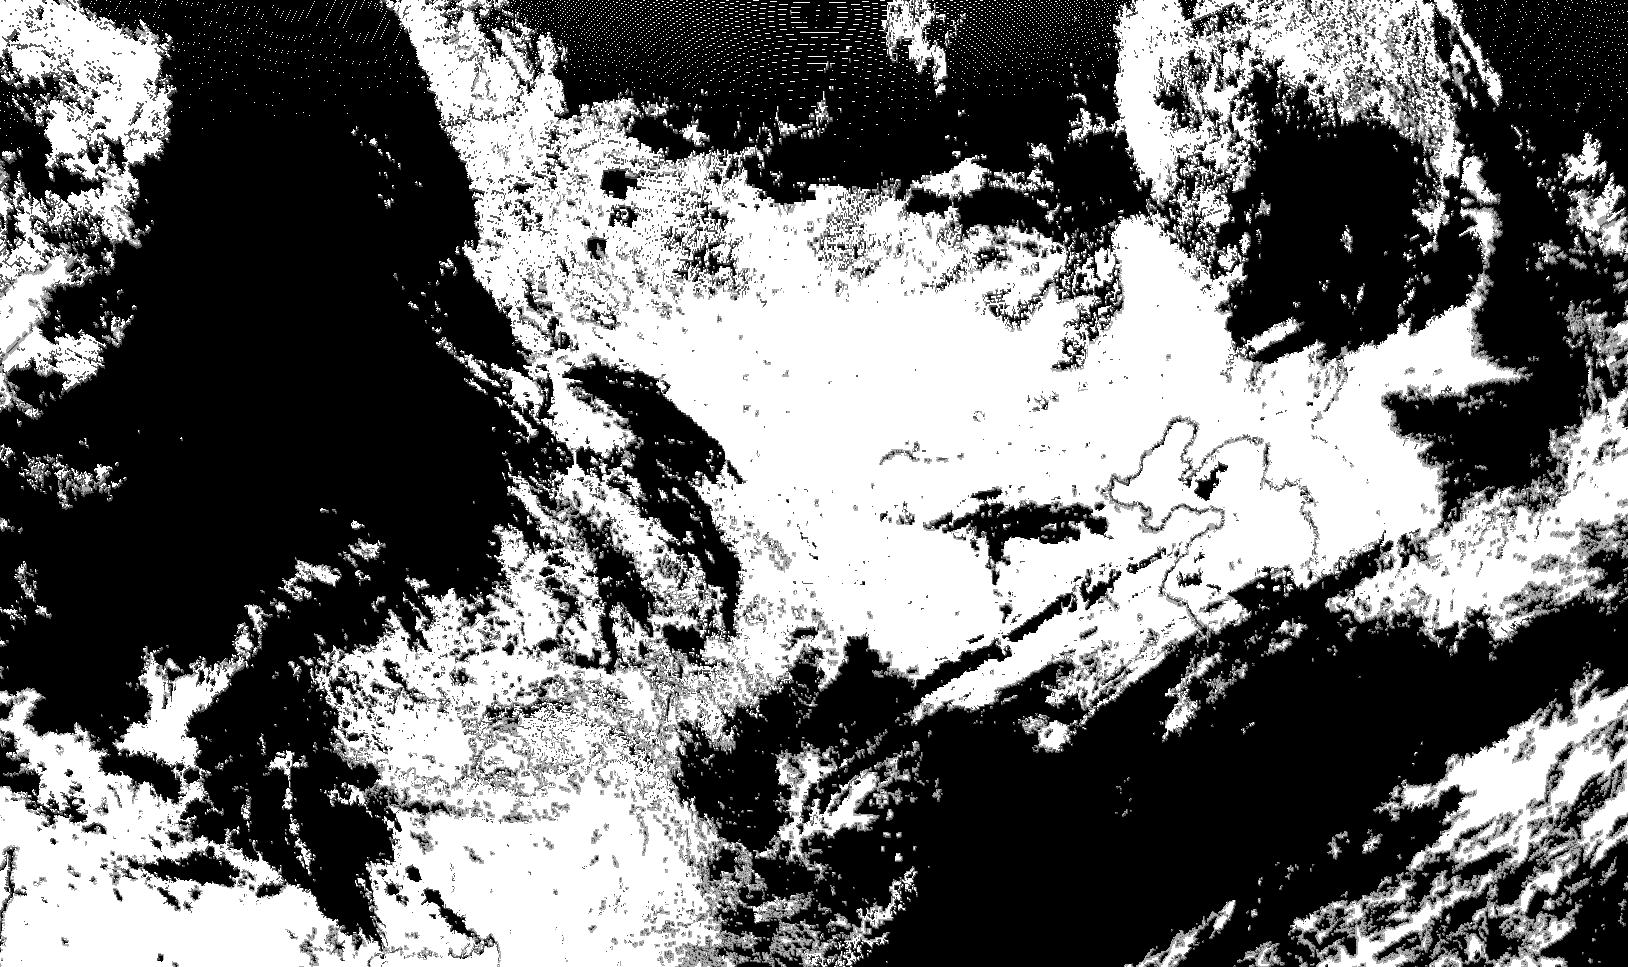

In [5]:

china_scene2 = scn2.resample('china_4km')
china_scene2.show('CLM')

# scn2 可视化

In [20]:
ds2 = scn2.to_xarray_dataset()

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_clm_classification(ds, clm):
    """
    绘制 CLM 分类图。

    参数:
        ds (xarray.Dataset): 包含 CLM 变量的数据集。
        clm (str): CLM 变量的名称（如 'CLM'）。
    """
    # 提取 CLM 数据
    clm_data = ds[clm].values  # 提取数据为 numpy 数组

    # 定义分类标签和颜色
    categories = {
        0: ("Cloud", "blue"),
        1: ("Probably Cloud", "cyan"),
        2: ("Probably Clear", "yellow"),
        3: ("Clear", "green"),
        126: ("Space", "black"),
        127: ("Fill Value", "grey")
    }

    # 创建离散颜色映射
    colors = [color for _, color in categories.values()]
    cmap = mcolors.ListedColormap(colors)

    # 定义颜色边界（每个类别的中间值）
    bounds = [0, 1, 2, 3, 126, 127, 128]  # 最后一个边界为127+1
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # 绘制图像
    plt.figure(figsize=(10, 8))
    img = plt.imshow(clm_data, cmap=cmap, norm=norm)

    # 添加颜色条
    cbar = plt.colorbar(img, ticks=[0.5, 1.5, 2.5, 63.5, 126.5, 127.5], shrink=0.8)
    cbar.ax.set_yticklabels([label for label, _ in categories.values()])

    # 添加标题和标签
    plt.title('CLM Classification')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.show()

In [ ]:
plot_clm_classification(ds2,'CLM')

In [3]:
china_scene2 = scn2.resample('china_4km')
ds3 = china_scene2.to_xarray_dataset()


In [6]:
plot_clm_classification(ds3,'CLM')

In [22]:
import numpy as np

# 提取 CLM 数据
clm_data = ds2['CLM'].values  # 将 CLM 数据转换为 numpy 数组

# 定义分类标签
categories = {
    0: "Cloud",
    1: "Probably Cloud",
    2: "Probably Clear",
    3: "Clear",
    126: "Space",
    127: "Fill Value"
}

# 统计每个类别的像元数
for value, label in categories.items():
    count = np.sum(clm_data == value)  # 统计等于当前值的像元数
    print(f"{label} ({value}): {count} pixels")

In [2]:
scn2.show('CLM')

In [3]:
import fnmatch

filename = "FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC"
pattern = "FY4B-_AGRI--_N_DISK_*_L2-_CLM-_*.NC"

if fnmatch.fnmatch(filename, pattern):
    print("✅ 文件名匹配模式")
else:
    print("❌ 文件名不匹配模式")

In [7]:
from satpy.readers import load_reader

# 1. 加载读取器配置
reader = load_reader(['/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/etc/readers/agri_fy4b_l2.yaml'])

# 2. 检查文件匹配
matched_files = reader.select_files_from_pathnames([clm_file_path])
print("匹配到的文件:", matched_files)  # 预期输出非空列表

# 3. 初始化处理器（触发调试输出）
if matched_files:
    handler = reader.create_filehandlers(matched_files[0])
    print("处理器初始化成功!")
    


In [10]:
type(handler)

In [ ]:
CTT_file_path = '/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CTT-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'



logging.basicConfig(level=logging.DEBUG)  # 显示详细日志
scn2 = Scene(reader = 'agri_fy4b_l2' , filenames = [CTT_file_path])
scn2.load(['cloud_mask'])
print(scn2.available_dataset_names())


In [ ]:
cp /Users/liyujia/Projects/FY4B-data-processing/configs/__init__.py \
   /Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/readers/

In [ ]:
                                       
cp /Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/readers/__init__.py.py \
   /Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/readers/__init__.py.py.bak

In [ ]:
cat __init__.py > /Users/liyujia/Projects/FY4B-data-processing/configs/__init__.py

In [ ]:

def _get_reader_kwargs(reader, reader_kwargs):
    """Help load_readers to form reader_kwargs.

    Helper for load_readers to get reader_kwargs and
    reader_kwargs_without_filter in the desirable form.
    """
    reader_kwargs = reader_kwargs or {}

    # ensure one reader_kwargs per reader, None if not provided
    if reader is None:
        reader_kwargs = {None: reader_kwargs}
    elif reader_kwargs.keys() != set(reader):
        reader_kwargs = dict.fromkeys(reader, reader_kwargs)

    reader_kwargs_without_filter = {}
    for (k, v) in reader_kwargs.items():
        reader_kwargs_without_filter[k] = v.copy()
        reader_kwargs_without_filter[k].pop("filter_parameters", None)

    return (reader_kwargs, reader_kwargs_without_filter)



In [ ]:
def _get_reader_and_filenames(reader, filenames):
    if reader is None and isinstance(filenames, dict):
        # filenames is a dictionary of reader_name -> filenames
        reader = list(filenames.keys())
        remaining_filenames = set(f for fl in filenames.values() for f in fl)
    elif reader and isinstance(filenames, dict):
        # filenames is a dictionary of reader_name -> filenames
        # but they only want one of the readers
        filenames = filenames[reader]
        remaining_filenames = set(filenames or [])
    else:
        remaining_filenames = set(filenames or [])
    return reader, filenames, remaining_filenames

In [ ]:

def load_readers(filenames=None, reader=None, reader_kwargs=None):
    """Create specified readers and assign files to them.

    Args:
        filenames (iterable or dict): A sequence of files that will be used to load data from. A ``dict`` object
                                      should map reader names to a list of filenames for that reader.
        reader (str or list): The name of the reader to use for loading the data or a list of names.
        reader_kwargs (dict): Keyword arguments to pass to specific reader instances.
            This can either be a single dictionary that will be passed to all
            reader instances, or a mapping of reader names to dictionaries.  If
            the keys of ``reader_kwargs`` match exactly the list of strings in
            ``reader`` or the keys of filenames, each reader instance will get its
            own keyword arguments accordingly.

    Returns: Dictionary mapping reader name to reader instance

    """
    reader_instances = {}
    if _early_exit(filenames, reader):
        return {}

    reader, filenames, remaining_filenames = _get_reader_and_filenames(reader, filenames)
    (reader_kwargs, reader_kwargs_without_filter) = _get_reader_kwargs(reader, reader_kwargs)

    if reader_kwargs is None:
        reader_kwargs = {}

    for idx, reader_configs in enumerate(configs_for_reader(reader)):
        readers_files = _get_readers_files(filenames, reader, idx, remaining_filenames)
        reader_instance = _get_reader_instance(reader, reader_configs, idx, reader_kwargs)
        if reader_instance is None or not readers_files:
            # Reader initiliasation failed or no files were given
            continue

        loadables = reader_instance.select_files_from_pathnames(readers_files)
        if loadables:
            reader_instance.create_storage_items(
                    loadables,
                    fh_kwargs=reader_kwargs_without_filter[None if reader is None else reader[idx]])
            reader_instances[reader_instance.name] = reader_instance
            remaining_filenames -= set(loadables)

        if not remaining_filenames:
            break

    _check_remaining_files(remaining_filenames)
    _check_reader_instances(reader_instances)
    return reader_instances

In [ ]:
def _create_reader_instances(self,
                                filenames=None,
                                reader=None,
                                reader_kwargs=None):
    """Find readers and return their instances."""
    return load_readers(filenames=filenames,
                        reader=reader,
                        reader_kwargs=reader_kwargs)


In [8]:

from parse import parse

pattern = "{platform:4s}-{dummy1}_{sensor:4s}-{dummy2}_N_DISK_{unknown1:4s}E_L2-_{product:3s}_{dummy3}_{dummy4}_s{start_time:%Y%m%d%H%M%S%f}_e{end_time:%Y%m%d%H%M%S%f}_{unknown2}_{version}.NC"

filename = "FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC"

result = parse(pattern, filename)
print("Parsing result:", result)
if result is not None:
    print("Matched groups:")
    print(result.named)
else:
    print("No match!")



In [1]:
from parse import parse

pattern = (
    "{platform}-"            # "FY4B-"
    "_{sensor}--"            # "_AGRI--"
    "_N_DISK_{unknown1}E_L2-"# "_N_DISK_1050E_L2-"
    "_{product}-"            # "_CLM-"
    "_{dummy3}_{dummy4}_"    # "_MULT_NOM_"
    "{start_time:%Y%m%d%H%M%S}_"  # "20250226070000_"
    "{end_time:%Y%m%d%H%M%S}_"    # "20250226071459_"
    "{unknown2}_"                 # "4000M_"
    "V{version}.NC"               # "V0001.NC"
)

filename = "FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC"

result = parse(pattern, filename)
print("Parsing result:", result)

if result is not None:
    print("\nMatched groups:")
    for k, v in result.named.items():
        print(f"  {k}: {v}")
else:
    print("No match!")


In [3]:
from parse import parse

filename = "FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC"

pattern = (
    "{platform:4s}-"
    "{dummy1}_"
    "{sensor:4s}--"
    "_N_DISK_"
    "{unknown1:4s}E"
    "_L2-_"
    "{product:3s}-"
    "_MULT_NOM_"
    "s{start_time:%Y%m%d%H%M%S}_"
    "e{end_time:%Y%m%d%H%M%S}_"
    "{resolution}_{version}.NC"
)

result = parse(pattern, filename)
print("Parsing result:", result)
if result is not None:
    print("\nMatched groups:")
    print(f"Platform: {result['platform']}")       # FY4B
    print(f"Sensor: {result['sensor']}")          # AGRI
    print(f"Product: {result['product']}")        # CLM
    print(f"Start Time: {result['start_time']}")  # 2025-02-26 07:00:00
    print(f"End Time: {result['end_time']}")      # 2025-02-26 07:14:59
    print(f"Version: {result['version']}")        # V0001
else:
    print("No match!")

In [ ]:

scn = Scene(reader="agri_fy4b_l2", filenames=[clm_file_path])
scn.load(["cloud_mask"])


In [ ]:





# 假设你的文件路径和读取器名称
filenames = ['/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC']
reader = 'agri_fy4b_l2'


In [ ]:
from trollsift import parse

filename = "FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC"
pattern = "{platform_id:4s}-_{instrument:4s}--_N_{observation_type:s}_{longitude:5s}_L2-_{product:s}-_MULT_{projection:s}_{start_time:%Y%m%d%H%M%S}_{end_time:%Y%m%d%H%M%S}_{resolution:4s}M_{version:s}.NC"

try:
    parsed = parse(pattern, filename)
    print("✅ 解析成功:", parsed)
except Exception as e:
    print("❌ 解析失败:", str(e))

In [ ]:
{'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'}

In [11]:
from trollsift.parser import globify, parse
from fnmatch import fnmatch
import os

In [12]:
def _get_filebase(path, pattern):
    """Get the end of *path* of same length as *pattern*."""
    # convert any `/` on Windows to `\\`
    path = os.path.normpath(path)
    # A pattern can include directories
    tail_len = len(pattern.split(os.path.sep))
    return os.path.join(*str(path).split(os.path.sep)[-tail_len:])

In [13]:
def _match_filenames(filenames, pattern):
    matching = set()
    glob_pat = globify(pattern)
    print(f"转换后的glob模式: {glob_pat}")
    
    for filename in filenames:
        base = _get_filebase(filename, pattern)
        print(f"文件基础名: {base}")
        if fnmatch(base, glob_pat):
            matching.add(filename)
            print(f"匹配成功!")
    
    return matching

In [14]:
# 输入的完整路径
path = ["/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC"]

# pattern
pattern = "FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_*.NC"

# # _get_filebase 会返回与 pattern 长度相同的文件名部分
# filebase = "FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC"





In [15]:
_match_filenames(path, pattern)

# 测试等经纬度投影

In [10]:
import os, glob
from satpy.scene import Scene
import os
import xarray as xr
import numpy as np
from datetime import datetime
import logging
import json


In [11]:


clm_file_path = '/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'


logging.basicConfig(level=logging.DEBUG)  # 显示详细日志
scn2 = Scene(reader = 'agri_fy4b_l2' , filenames = [clm_file_path])
scn2.load(['CLM'])
# print(scn2.available_dataset_names())


filenames = glob.glob('/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_*_4000M_V*.HDF')
# 创建scene对象
scn = Scene(filenames,reader='agri_fy4b_l1')

channels = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 
           'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15']
scn.load(channels, generate=False)

area = 'china_4km_eqc'

china_scene_l1 = scn.resample(area)
china_scene_l2 = scn2.resample(area)


ds = china_scene_l1.to_xarray_dataset()
ds2 = china_scene_l2.to_xarray_dataset()


# Add time dimension if needed
ds = ds.expand_dims(dim={'time': [datetime(2025,2,26,7,0,2)]})  # Adjust date as needed
ds2 = ds2.expand_dims(dim={'time': [datetime(2025,2,26,7,0,2)]})

# 合并两个数据集
ds_combined = xr.merge([ds, ds2])


# Improved function to sanitize attributes for NetCDF compatibility
def sanitize_attrs_for_netcdf(attrs):
    """Recursively clean attribute dictionary for NetCDF compatibility by converting complex types to strings"""
    sanitized = {}
    for key, value in attrs.items():
        if isinstance(value, (np.ndarray, np.generic)):
            # Convert NumPy arrays and scalars to Python types
            if np.isscalar(value) or value.size == 1:
                sanitized[key] = value.item()
            else:
                sanitized[key] = value.tolist()
        elif isinstance(value, (list, tuple)) and all(isinstance(x, (int, float, str, bool)) for x in value):
            # Keep simple lists/tuples of primitive types
            sanitized[key] = list(value)  
        elif isinstance(value, (int, float, str, bool)):
            # Keep primitive types
            sanitized[key] = value
        elif isinstance(value, bytes):
            # Keep bytes
            sanitized[key] = value
        else:
            # Convert everything else (including dictionaries, custom objects) to string
            try:
                sanitized[key] = json.dumps(value)
            except (TypeError, OverflowError):
                sanitized[key] = str(value)
    
    return sanitized



# 清理数据集属性
ds_combined.attrs = sanitize_attrs_for_netcdf(ds_combined.attrs)

# 清理变量属性
for var_name in ds_combined.variables:
    ds_combined[var_name].attrs = sanitize_attrs_for_netcdf(ds_combined[var_name].attrs)

# 处理 CRS 变量问题
if 'crs' in ds_combined.variables:
    if hasattr(ds_combined.crs, 'attrs') and 'spatial_ref' in ds_combined.crs.attrs:
        ds_combined.attrs['crs_wkt'] = str(ds_combined.crs.attrs.get('spatial_ref', ''))
    else:
        ds_combined.attrs['crs_wkt'] = str(ds_combined.crs.values)
    ds_combined = ds_combined.drop_vars('crs')

# 定义 NetCDF 编码
channels = [f'C{str(i).zfill(2)}' for i in range(1, 16)]  # C01 to C15
encoding = {
    channel: {
        'chunksizes': (1, 500, 500),
        'zlib': True,
        'complevel': 3,
        'dtype': 'float32',
    } for channel in channels if channel in ds_combined.data_vars
}

# 添加坐标和其他变量的编码
for coord in ds_combined.coords:
    if coord not in encoding:
        encoding[coord] = {'zlib': True}

# 添加 CLM 的编码
if 'CLM' in ds_combined.data_vars:
    encoding['CLM'] = {
        'chunksizes': (1, 500, 500),
        'zlib': True,
        'complevel': 3,
        'dtype': 'float32',
    }

# 保存为 NetCDF 文件
output_path = '/Users/liyujia/Projects/FY4B-data-processing/FY4B_CloudBase.nc'
ds_combined.chunk({'time': 1, 'y': 500, 'x': 500}).to_netcdf(
    output_path,
    encoding=encoding,
    unlimited_dims=['time'],
    engine='netcdf4',
    format='NETCDF4'
)

print(f"Successfully saved to {output_path}")


/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/readers/agri_l2.py:56: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.ncols = self.nc.dims["x"]
/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/readers/agri_l2.py:57: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.nlines = self.nc.dims["y"]


🔄 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'}, 选择文件类型: ['/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/etc/readers/agri_fy4b_l2.yaml']
 init 传参 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'}
🟢 读取数据集: DataID(name='CLM', calibration=<calibration.counts>, modifiers=()), info: {'name': 'CLM', 'file_key': 'CLM', 'standard_name': 'cloud_mask', 'file_type': 'clm', 'fill_value': 127, 'calibration': <calibration.counts>, 'modifiers': ()}
🔄 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.HDF'}, 选择文件类型: ['/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/etc/readers/agri_fy4b_l1.yaml']
 init 传参 选择文件: {'/Users/liyujia/Projects/FY4

INFO:satpy.resample:Using default KDTree resampler
INFO:satpy.resample:Using default KDTree resampler


/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))
/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


Successfully saved to /Users/liyujia/Projects/FY4B-data-processing/FY4B_CloudBase.nc


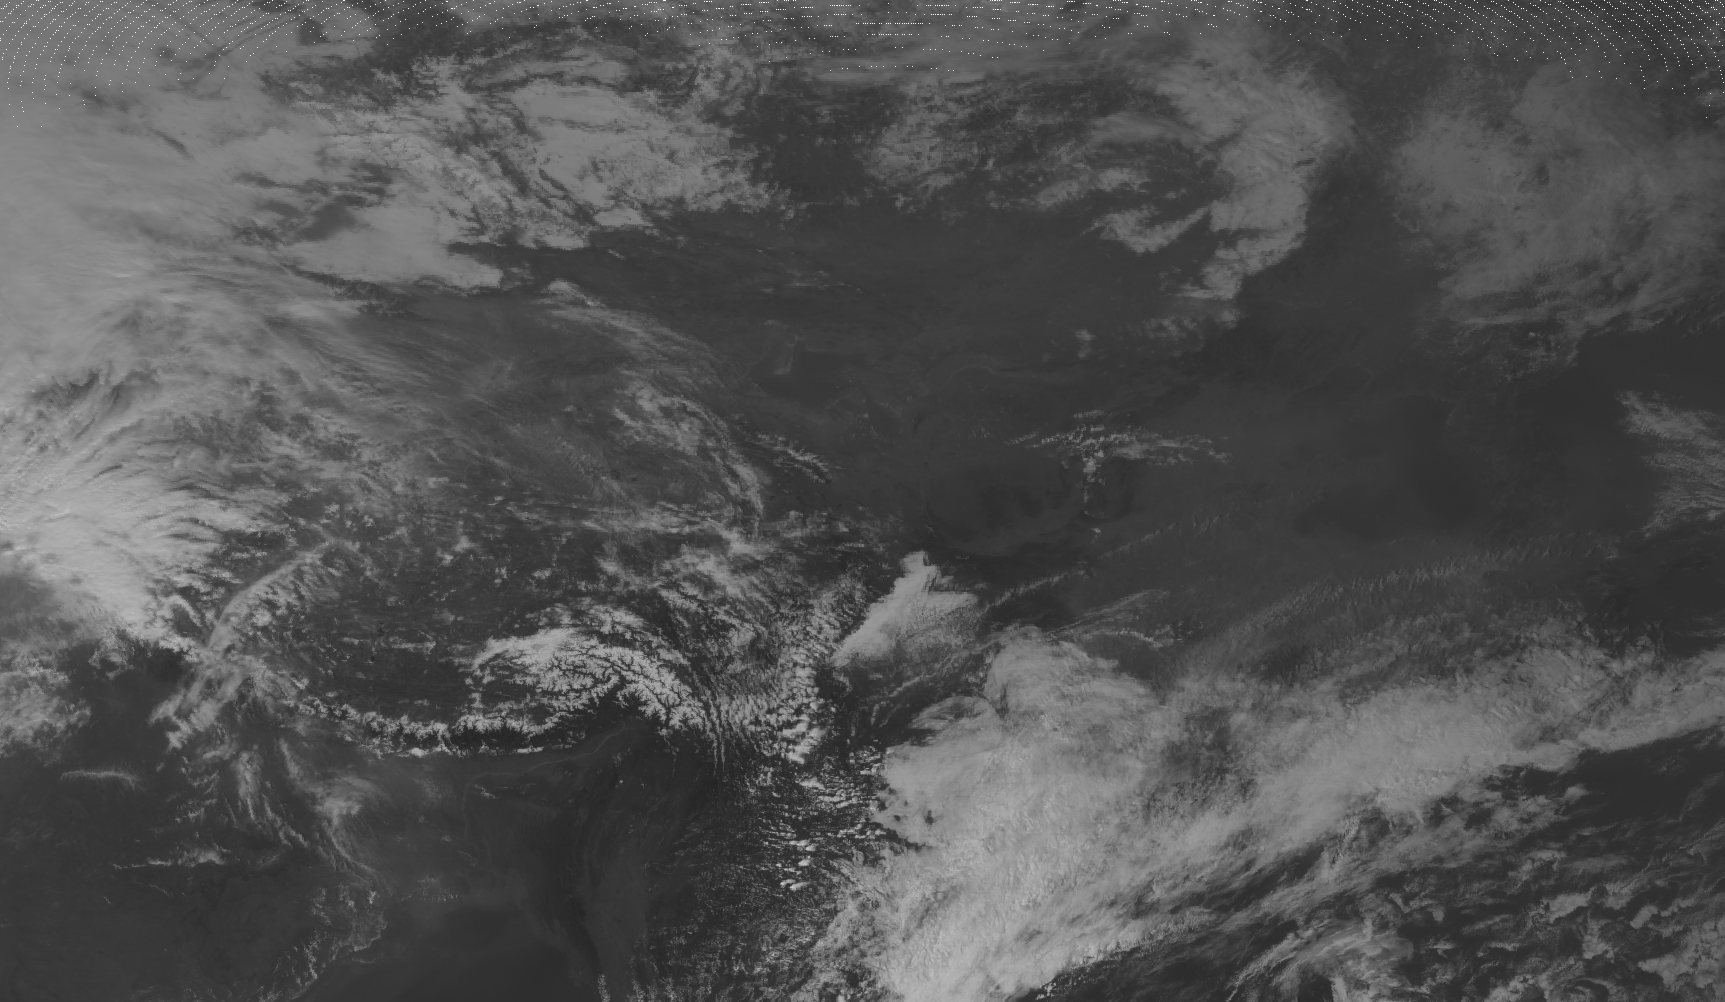

In [13]:
china_scene_l1.show('C01')

/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))


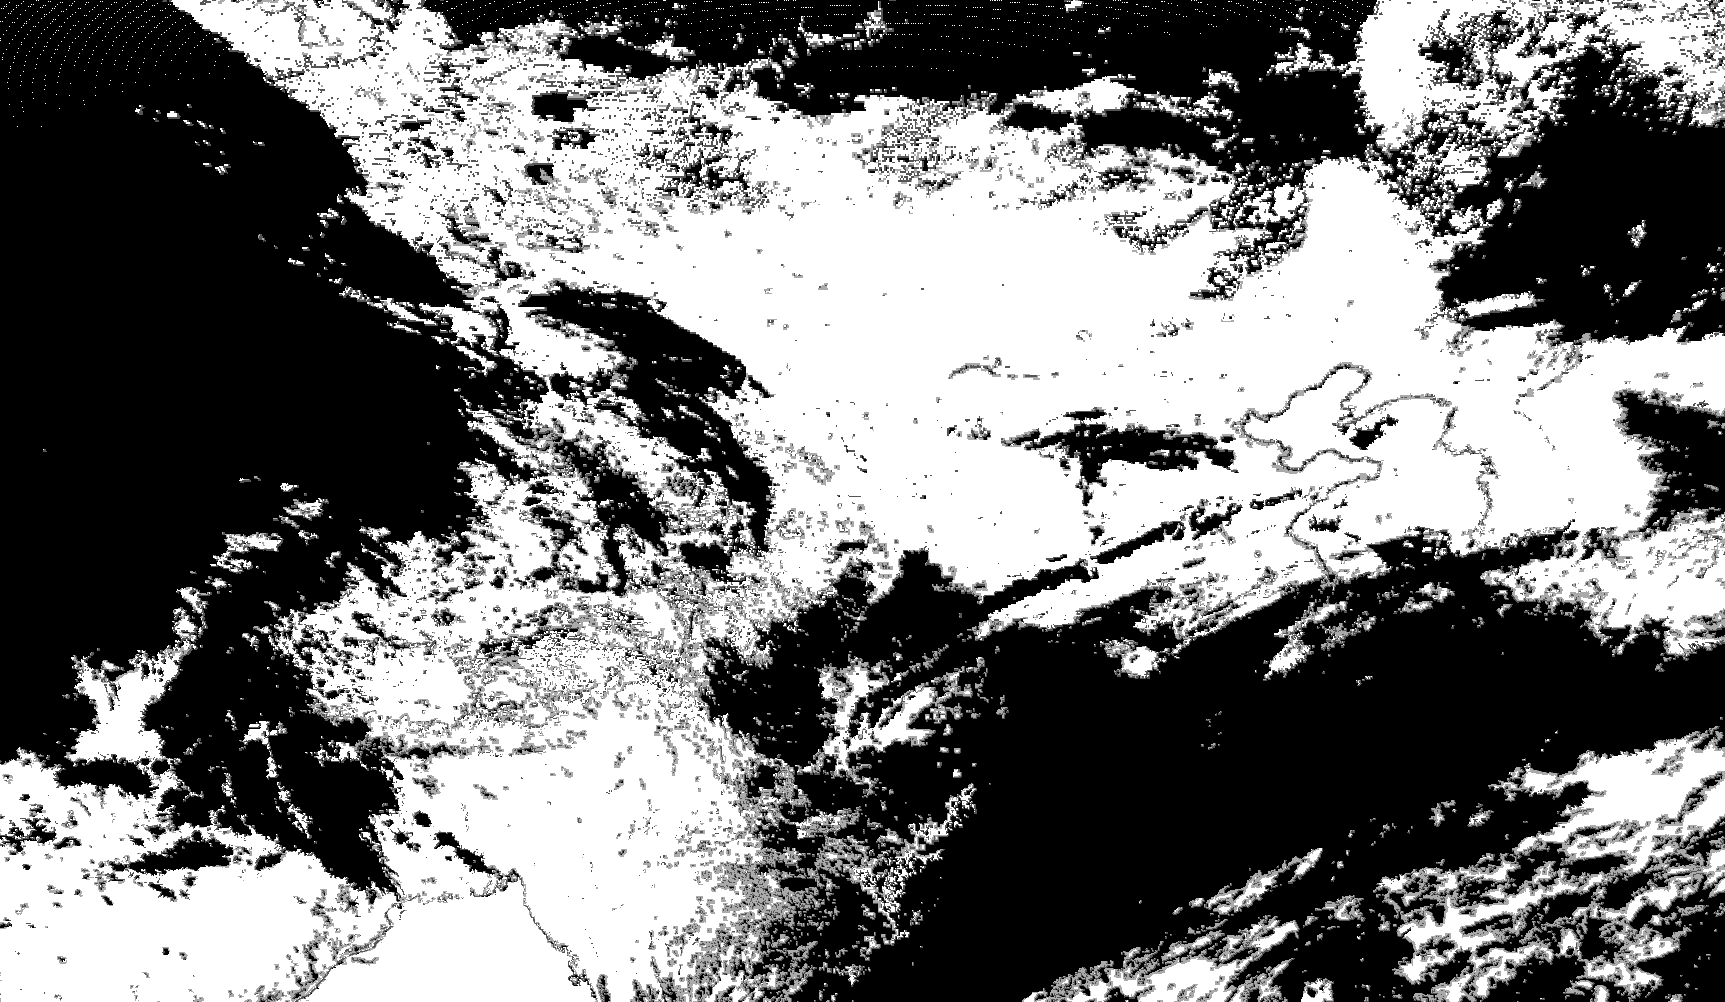

In [14]:
china_scene_l2.show('CLM')

# 添加lat 和 lon

In [1]:
import os, glob
from satpy.scene import Scene
import os
import xarray as xr
import numpy as np
from datetime import datetime
import logging
import json
from pyproj import Proj, Transformer


In [2]:




clm_file_path = '/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'


logging.basicConfig(level=logging.DEBUG)  # 显示详细日志
scn2 = Scene(reader = 'agri_fy4b_l2' , filenames = [clm_file_path])
scn2.load(['CLM'])
# print(scn2.available_dataset_names())


filenames = glob.glob('/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_*_4000M_V*.HDF')
# 创建scene对象
scn = Scene(filenames,reader='agri_fy4b_l1')

channels = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 
           'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15']
scn.load(channels, generate=False)

area = 'china_4km_eqc'

china_scene_l1 = scn.resample(area)
china_scene_l2 = scn2.resample(area)


ds = china_scene_l1.to_xarray_dataset()
ds2 = china_scene_l2.to_xarray_dataset()


# Add time dimension if needed
ds = ds.expand_dims(dim={'time': [datetime(2025,2,26,7,0,2)]})  # Adjust date as needed
ds2 = ds2.expand_dims(dim={'time': [datetime(2025,2,26,7,0,2)]})

# 合并两个数据集
ds_combined = xr.merge([ds, ds2])


# Improved function to sanitize attributes for NetCDF compatibility
def sanitize_attrs_for_netcdf(attrs):
    """Recursively clean attribute dictionary for NetCDF compatibility by converting complex types to strings"""
    sanitized = {}
    for key, value in attrs.items():
        if isinstance(value, (np.ndarray, np.generic)):
            # Convert NumPy arrays and scalars to Python types
            if np.isscalar(value) or value.size == 1:
                sanitized[key] = value.item()
            else:
                sanitized[key] = value.tolist()
        elif isinstance(value, (list, tuple)) and all(isinstance(x, (int, float, str, bool)) for x in value):
            # Keep simple lists/tuples of primitive types
            sanitized[key] = list(value)  
        elif isinstance(value, (int, float, str, bool)):
            # Keep primitive types
            sanitized[key] = value
        elif isinstance(value, bytes):
            # Keep bytes
            sanitized[key] = value
        else:
            # Convert everything else (including dictionaries, custom objects) to string
            try:
                sanitized[key] = json.dumps(value)
            except (TypeError, OverflowError):
                sanitized[key] = str(value)
    
    return sanitized



# 清理数据集属性
ds_combined.attrs = sanitize_attrs_for_netcdf(ds_combined.attrs)

# 清理变量属性
for var_name in ds_combined.variables:
    ds_combined[var_name].attrs = sanitize_attrs_for_netcdf(ds_combined[var_name].attrs)

# 处理 CRS 变量问题
if 'crs' in ds_combined.variables:
    if hasattr(ds_combined.crs, 'attrs') and 'spatial_ref' in ds_combined.crs.attrs:
        ds_combined.attrs['crs_wkt'] = str(ds_combined.crs.attrs.get('spatial_ref', ''))
    else:
        ds_combined.attrs['crs_wkt'] = str(ds_combined.crs.values)
    ds_combined = ds_combined.drop_vars('crs')

# 定义 NetCDF 编码
channels = [f'C{str(i).zfill(2)}' for i in range(1, 16)]  # C01 to C15
encoding = {
    channel: {
        'chunksizes': (1, 500, 500),
        'zlib': True,
        'complevel': 3,
        'dtype': 'float32',
    } for channel in channels if channel in ds_combined.data_vars
}

# 添加坐标和其他变量的编码
for coord in ds_combined.coords:
    if coord not in encoding:
        encoding[coord] = {'zlib': True}

# 添加 CLM 的编码
if 'CLM' in ds_combined.data_vars:
    encoding['CLM'] = {
        'chunksizes': (1, 500, 500),
        'zlib': True,
        'complevel': 3,
        'dtype': 'float32',
    }


# 在合并数据集后添加以下代码 -------------------------------------------------

# 获取投影参数（根据你的 area 定义）
proj_params = {
    'proj': 'eqc',
    'ellps': 'WGS84',
    'lat_0': 36.0,
    'lon_0': 104.0
}

# 创建投影转换器
p = Proj(**proj_params)

# 生成 x/y 网格坐标（假设你的坐标名是 'x' 和 'y'）
xx, yy = np.meshgrid(ds_combined['x'].values, ds_combined['y'].values)

# 转换为经纬度
transformer = Transformer.from_proj(p, "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(xx, yy)

# 将经纬度添加到数据集
ds_combined['longitude'] = (('y', 'x'), lon)
ds_combined['latitude'] = (('y', 'x'), lat)

# 为坐标添加元数据
ds_combined['longitude'].attrs = {
    'long_name': 'longitude',
    'units': 'degrees_east',
    'standard_name': 'longitude'
}

ds_combined['latitude'].attrs = {
    'long_name': 'latitude',
    'units': 'degrees_north',
    'standard_name': 'latitude'
}

# 确保设置坐标系
ds_combined = ds_combined.set_coords(['longitude', 'latitude'])

# -------------------------------------------------------------------------

DEBUG:satpy.readers.yaml_reader:Reading ('/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/etc/readers/agri_fy4b_l2.yaml',)


🔄 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'}, 选择文件类型: ['/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/etc/readers/agri_fy4b_l2.yaml']


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:satpy.readers.yaml_reader:Assigning to agri_fy4b_l2: ['/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC']
/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/readers/agri_l2.py:56: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.ncols = self.nc.dims["x"]
/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/readers/agri_l2.py:57: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more con

 init 传参 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L2/FY4B-_AGRI--_N_DISK_1050E_L2-_CLM-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.NC'}


DEBUG:pyorbital.tlefile:Path to the Pyorbital configuration (where e.g. platforms.txt is found): /Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/pyorbital/etc
DEBUG:satpy.readers.yaml_reader:Reading ('/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/etc/readers/agri_fy4b_l1.yaml',)
DEBUG:satpy.readers.yaml_reader:Assigning to agri_fy4b_l1: ['/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.HDF']
DEBUG:satpy.readers.agri_l1:Reading in get_dataset C01.
DEBUG:satpy.readers.fy4_base:Calibrating to reflectances
DEBUG:satpy.readers.agri_l1:Reading in get_dataset C11.
DEBUG:satpy.readers.fy4_base:Calibrating to brightness_temperature
DEBUG:satpy.readers.agri_l1:Reading in get_dataset C10.
DEBUG:satpy.readers.fy4_base:Calibrating to brightness_temperature
DEBUG:satpy.readers.agri_l1:Reading in get_dataset C14.
DEBUG:satpy.readers.fy4_base:Calibrating to brigh

🟢 读取数据集: DataID(name='CLM', calibration=<calibration.counts>, modifiers=()), info: {'name': 'CLM', 'file_key': 'CLM', 'standard_name': 'cloud_mask', 'file_type': 'clm', 'fill_value': 127, 'calibration': <calibration.counts>, 'modifiers': ()}
🔄 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.HDF'}, 选择文件类型: ['/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/satpy/etc/readers/agri_fy4b_l1.yaml']
 init 传参 选择文件: {'/Users/liyujia/Projects/FY4B-data-processing/data/raw/L1/4000M/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250226070000_20250226071459_4000M_V0001.HDF'}


DEBUG:satpy.readers.agri_l1:Reading in get_dataset C12.
DEBUG:satpy.readers.fy4_base:Calibrating to brightness_temperature
DEBUG:satpy.readers.agri_l1:Reading in get_dataset C02.
DEBUG:satpy.readers.fy4_base:Calibrating to reflectances
DEBUG:satpy.readers.agri_l1:Reading in get_dataset C15.
DEBUG:satpy.readers.fy4_base:Calibrating to brightness_temperature
DEBUG:satpy.readers.agri_l1:Reading in get_dataset C13.
DEBUG:satpy.readers.fy4_base:Calibrating to brightness_temperature
DEBUG:satpy.readers.agri_l1:Reading in get_dataset C07.
DEBUG:satpy.readers.fy4_base:Calibrating to brightness_temperature
DEBUG:satpy.readers.agri_l1:Reading in get_dataset C03.
DEBUG:satpy.readers.fy4_base:Calibrating to reflectances
DEBUG:satpy.readers.agri_l1:Reading in get_dataset C04.
DEBUG:satpy.readers.fy4_base:Calibrating to reflectances
DEBUG:satpy.scene:Resampling DataID(name='C01', wavelength=WavelengthRange(min=0.45, central=0.47, max=0.49, unit='µm'), resolution=4000, calibration=<calibration.reflec

In [3]:

# 保存为 NetCDF 文件
output_path = '/Users/liyujia/Projects/FY4B-data-processing/FY4B_CloudBase_lat_lon.nc'
ds_combined.chunk({'time': 1, 'y': 500, 'x': 500}).to_netcdf(
    output_path,
    encoding=encoding,
    unlimited_dims=['time'],
    engine='netcdf4',
    format='NETCDF4'
)

print(f"Successfully saved to {output_path}")


/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/Users/liyujia/miniconda3/envs/FY4/lib/python3.10/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


Successfully saved to /Users/liyujia/Projects/FY4B-data-processing/FY4B_CloudBase_lat_lon.nc


# 训练AE

In [ ]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# from method.utils.pytorch_copy import ModisGlobalTilesDataset
from method.utils.utils import sample_tiles_swath, plot_tile, tile_predict_cbh, CloudBaseHeightPrediction,load_means_stds
home_dir = os.getcwd()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from method.models.models import ConvAutoEncoder
from method.models.models_jinzhi import ConvAutoEncoder
from method.utils.pytorch_class import ModisGlobalTilesDataset



In [ ]:

data_dir = home_dir + '/data/example/tiles/'
means_stds_file = home_dir+'/data/example/means_stds_save.txt'  
model_save_dir = home_dir + '/method/models/models_save/'




learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# 加载均值和标准差
means, stds, mins, _ = load_means_stds(means_stds_file,log_transform = False)
param_cols = ['cloud_top_height', 'cloud_optical_thickness', 'cloud_water_path']
subset = [0, 1, 2]  # 对应于上述参数的索引